# Notebook 1: Downloading data

The goal of this notebook is to download all paper metadata from PubMed, and citation data from Google Scholar.

## Downloading PubMed data

In [ ]:
! python ../data/download_pubmed_citations.py

We use the eFetch utility from NCBI eUtils, and download the entire xml for each citation. 10K entries is 5-10 MB (so <1KB per entry) after stripping out extraneous information.

Run the following command: `python ../data/download_pubmed_citations.py` to run this multicore for all 28M articles. The below code was used during testing.

In [118]:
from Bio import Entrez
from pprint import pprint
import sys
import cPickle as pickle
import glob
import os

In [207]:
# Code to take only the relevant fields from the PubMed XML summary

def simplify(info):
    record = {}
    article = info['MedlineCitation']['Article']

    record["pmid"] = int(info['MedlineCitation']['PMID'])
    record["title"] = article['ArticleTitle']
    try: record["journal"] = article['Journal']['Title']
    except: record["journal"] = ""
    try: record["jabbr"] = article['Journal']['ISOAbbreviation']
    except: record["jabbr"] = ""
    #record["year"] = article['Journal']['JournalIssue']['PubDate']['Year']
    record["yr"] = dict(info['PubmedData']['History'][0])['Year']
    record["mo"] = dict(info['PubmedData']['History'][0])['Month']
    record["keywords"] = info['MedlineCitation']['KeywordList']
    try:
        record["authors"] = []
        for au in article["AuthorList"]:
            record["authors"].append([au["LastName"], au["ForeName"], au["Initials"], au["AffiliationInfo"]])
    except: pass
    return record

In [ ]:
# I ran this in download_pubmed_citations.py

Entrez.email = 'bdo311@gmail.com'
if not glob.glob("../data/pubmed/"): os.mkdir("../data/pubmed")
    
for z in range(0, 29000000, 100000):
    print z
    pmids = [str(i) for i in range(z, z + 100000)]
    handle = Entrez.efetch(db="pubmed", id=pmids, retmode="xml")
    #records = Medline.parse(handle)
    records = Entrez.read(handle)["PubmedArticle"]
    #print records
    # fields = ('PMID', 'AU', 'FAU', 'AD', 'IRAD', 'DP', 'TI', 'JT', 'TA', 'OT', 'PT', 'AID')
    # all_records = []

    records_slim = [simplify(x) for x in records]
    pickle.dump(records_slim, open("../data/pubmed/pubmed_{}.pkl".format(z), 'w'))

In [210]:
# Testing on a single paper

handle = Entrez.efetch(db="pubmed", id=127, retmode="xml")
records = Entrez.read(handle)["PubmedArticle"]
records_slim = [simplify(x) for x in list(records)]
print records_slim

[{'mo': '11', 'title': 'Editorial: Childhood poisoning: prevention and first-aid management.', 'jabbr': 'Br Med J', 'authors': [], 'keywords': [], 'pmid': 127, 'yr': '1975', 'journal': 'British medical journal'}]


In [164]:
# this is what the JSON output looks like for a single article

info = a[90000]
article = info['MedlineCitation']['Article']
pprint(dict(article))

{u'Abstract': {u'AbstractText': ['A preparation of ATPase from the membranes of Micrococcus lysodeikticus, solubilized and more than 95% pure, showed two main bands in analytical polyacrylamide gel electrophoresis. They did not correspond to isoenzymes because one band could be converted into the other by exposure to a mildly alkaline pH value. The conversion was paralleled by changes in molecular weight, circular dichroism and catalytic properties. Denaturation by pH at 25 degrees C was followed by means of circular dichroism, ultracentrifugation and polyacrylamide gel electrophoresis. A large conformational transition took place in the acid range with midpoints at about pH = 3.6 (I = 10(-4) M), 4.3 (I = 0.03 M) and 5.3 (I = 0.1 M). The transition was irreversible. Strong aggregation of the protein occurred in this range of pH. The final product was largely random coil, but even at pH 1.5 dissociation into individual subunits was not complete. However, partial dissociation took place 

## Downloading a list of papers that cite each paper

In [ ]:
! python ../data/download_pubmed_citing_papers.py

We use the eLink utility and save all PubMed papers that cite each paper. From that we can calculate c10.

Run `python ../data/download_pubmed_citing_papers.py` to run this in multicore. The following code was used for testing.

In [228]:
# https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?retmode=json&dbfrom=pubmed&id=26878240&cmd=neighbor&linkname=pubmed_pubmed_citedin
handle = Entrez.elink(dbfrom="pubmed", id=['23969737', '24803000'], cmd="neighbor", retmode="xml", linkname="pubmed_pubmed_citedin")
records = Entrez.read(handle)
# print a
# z = [int(x['Id']) for x in rec[0]['LinkSetDb'][0]['Link']] if rec[0]['LinkSetDb'] else []
# u = int(rec[0]['IdList'][0])
# print z, u

pmids = [int(rec['IdList'][0]) for rec in list(records)]
citing_papers = [[int(paper['Id']) for paper in rec['LinkSetDb'][0]['Link']] if rec['LinkSetDb'] else [] for rec in list(records)]

In [229]:
dict(zip(pmids, citing_papers))

{24803000: [27815943, 27679682, 27443611, 26989476, 26925040, 26667202, 26441955, 26350594, 26344953, 26279977, 26173587, 26075520, 26068237, 25879661, 25778531, 25750241, 25733520, 25714922, 25549696, 25436773], 23969737: [27791170, 27784796, 27630639, 27630231, 27610569, 27466419, 27442127, 27392606, 27349934, 27067056, 27064278, 27028935, 27001953, 26950744, 26933962, 26837192, 26827912, 26814372, 26763999, 26725118, 26709685, 26530382, 26527585, 26485194, 26468542, 26457756, 26454663, 26450412, 26446600, 26444083, 26413851, 26344344, 26332605, 26312747, 26248318, 26194759, 26136568, 26087072, 26068237, 26041300, 26039641, 26018167, 25972551, 25938510, 25889056, 25870266, 25837467, 25808207, 25803681, 25787288, 25785734, 25760931, 25747313, 25740988, 25662010, 25536486, 25525909, 25520506, 25512514, 25345460, 25298114, 25254639, 25215861, 25157148, 25153121, 25151483, 25142607, 25142591, 25132382, 25119033, 25046154, 24995008, 24982157, 24965460, 24917864, 24872420, 24803000, 248027

## Cleanup of citing papers data: merging individual pickle files into larger files, and making sure everything was downloaded properly

In [ ]:
ctr = 0
citations = {}
citation_counts = {}
for fn in glob.glob("../data/pubmed_citations/citations_*.pkl"):
    # print fn
    ctr += 1
    if ctr % 100 == 0: print ctr
    data = pickle.load(open(fn, 'r'))
    
    for z in data:
        if data[z]:
            citations[z] = data[z]
            citation_counts[z] = len(data[z])
            
pickle.dump((citations, citation_counts), open("../data/pubmed_citing_papers.pkl", 'w'))

Merging everything together and making a dictionary of citation counts. To save space, I am only keeping keys that have nonzero/non-empty values in the dictionaries.

In [270]:
# Citing papers
ctr = 0
for i in range(0, 29000000, 10000):
    if not glob.glob("../data/pubmed_citations/citations_{}.pkl".format(i)):
        print i
        ctr += 1
print ctr

0


In [279]:
len(citation_counts.keys())

12408806

In [285]:
import seaborn as sns
import numpy as np
%matplotlib inline

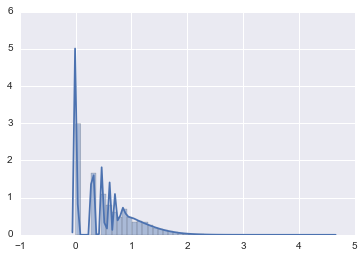

In [287]:
sns.distplot(np.log10(citation_counts.values()))

## Cleanup of citation metadata

In [280]:
# Citations
ctr = 0
for i in range(0, 29000000, 10000):
    if not glob.glob("../data/pubmed/pubmed_{}.pkl".format(i)):
        print i
        ctr += 1
print ctr

0


Get essential stats (num authors, year, journal, num citations) into one dictionary.

Throwing away all papers that don't have an author list or a year of publication, or have any other defects

In [295]:
ctr = 0
all_info = {}
for fn in glob.glob("../data/pubmed/pubmed_*.pkl"):
    ctr += 1
    if ctr % 100 == 0: print ctr
    data = pickle.load(open(fn, 'r'))
    
    for rec in data:
        pmid = rec['pmid']
        if rec["authors"] == [] or rec['yr'] == "": continue
        try: all_info[pmid] = (len(rec["authors"]), int(rec['yr']), rec['journal'], citation_counts[pmid])
        except: continue
            
pickle.dump(all_info, open("../data/pubmed_statistics.pkl", 'w'))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


KeyboardInterrupt: (None, <function _reconstructor at 0x10d587a28>, (<class 'Bio.Entrez.Parser.StringElement'>, <type 'str'>, 'MM'))

## Getting a controlled vocabulary of affiliations